<a href="https://colab.research.google.com/github/AshOne91/PLAYDATA-COLAB/blob/main/%EC%9E%90%EC%97%B0%EC%96%B4_%EB%94%A5%EB%9F%AC%EB%8B%9D_%EC%9D%91%EC%9A%A9(%EC%96%B8%EC%96%B4_%EB%AA%A8%EB%8D%B8%EB%A7%81).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Transformer
```
RNN/LSTM 의 한계
  순차처리 : 단어를 하나씩 읽어서 문맥을 이해, 초기 정보 잊음
  병렬화 불가 : GPU를 활용한 빠른 학습이 불가
Transformer 장점
  병렬 처리
  self-attention  : 단어간의 관계를 직접계산 긴 문맥도 잘 파악
Transformer의 전체 구조
  Encoder : 입력문장을 벡터로변환  "영화가 재미있다"->의미벡터
  Decoder : 출력문장생성, 번역.
    구성 : 인코더와 유사 + masked self-attention + encoder-decoder attention
  self-attention  : 단어간 중요도를 계산 "영화가" "재미있다" 강하게 연될
Positional Encoding : 단어의 위치를 나타내는 벡터를 추가
  방식 : 사인/코사인 함수로 고정된 위치벡터를 생성
```

self attention layer 구현

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from typing import Tuple
class SelfAttention(nn.Module):
  def __init__(self,embed_dim:int, num_heads:int  = 1):
    super().__init__()
    self.embed_dim = embed_dim
    self.num_heads = num_heads
    self.head_dim = embed_dim // num_heads  # 각 헤드가 처리할 feature 크기
    self.query = nn.Linear(embed_dim, embed_dim)
    self.key = nn.Linear(embed_dim, embed_dim)
    self.value = nn.Linear(embed_dim, embed_dim)
    # softmax 전에 값이 너무커지는 것을 방지해서 학습 안정화
    self.scale = torch.sqrt(torch.FloatTensor([self.head_dim]))
  def forward(self, x:torch.Tensor)->Tuple[torch.Tensor, torch.Tensor]:
    batch_size,seq_len,embed_dim = x.size()  # x.shape
    Q = self.query(x)
    K = self.key(x)
    V = self.value(x)
    # 멀티해드 분할 (batch_size, head수, seq길이,head차원) 형태로 분할
    # seq_len, num_heads 축을 swap --> 계산할때 해드별로 묶어서 편하게하려고
    Q = Q.view(batch_size,seq_len,self.num_heads,self.head_dim).transpose(1,2)
    K = K.view(batch_size,seq_len,self.num_heads,self.head_dim).transpose(1,2)
    V = V.view(batch_size,seq_len,self.num_heads,self.head_dim).transpose(1,2)
    # 어텐션 스코어(얼마나 주목할지)
    scores = torch.matmul(Q, K.transpose(-2,-1)) / self.scale
    attn_weight = torch.softmax(scores,dim=-1)  # 0~1 확률 가장중요한 토큰에 높은 점수를 주기위해서
    out = torch.matmul(attn_weight,V)
    # 헤드들을 다시 합쳐서 원래 차원으로 복원
    # batch_size, num_head, seq_len, head_dim -->
    # batch_size, seq_len, num_head, head_dim
    # contiguous 메모리 재 정렬해서 연속적인 배열형태로 만들어줌(view 에러 방지)
    out = out.transpose(1,2).contiguous().view(batch_size,seq_len,embed_dim)
    return out, attn_weight



In [ ]:
# 샘플데이터
batch_size = 1
seq_len = 5
embed_dim = 64
num_head = 1

# 임의의 임력데이터(토큰화된 데이터)
x = torch.randn(batch_size,seq_len,embed_dim)
print(f'입력 데이터 : {x.shape}')

# self-attention 적용
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SelfAttention(embed_dim,num_head).to(device)
x = x.to(device)
out, attn_weight = model(x)
print(f'출력 데이터 : {out.shape}')
print(f'어텐션 가중치 : {attn_weight.shape}') # 1 4 5 5  (batch,headnum,query seq, key seq)

입력 데이터 : torch.Size([1, 5, 64])
출력 데이터 : torch.Size([1, 5, 64])
어텐션 가중치 : torch.Size([1, 1, 5, 5])


In [ ]:
attn_weight[0,0,2,4]  # 0.2061  0번헤드에서 2번째 토큰(queyr) 4번째 토큰(key)를 0.206

tensor(0.1247, grad_fn=<SelectBackward0>)

어텐션 가중치 시각화

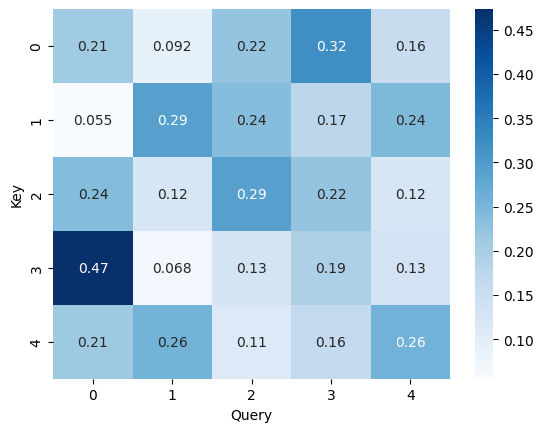

In [ ]:
# 첫번째해드 가중치 시각화 (쿼리와 키들의 어텐션 값)
import seaborn as sns
attn_weights = attn_weight[0,0].detach().cpu().numpy()
sns.heatmap(attn_weights, annot=True, cmap='Blues')
plt.xlabel('Query')
plt.ylabel('Key')
plt.show()


torch.Size([1, 5])
torch.Size([1, 5, 64])
샘플 출력 shpae : torch.Size([1, 5, 64])
어텐션 가중치 shape : torch.Size([1, 1, 5, 5])


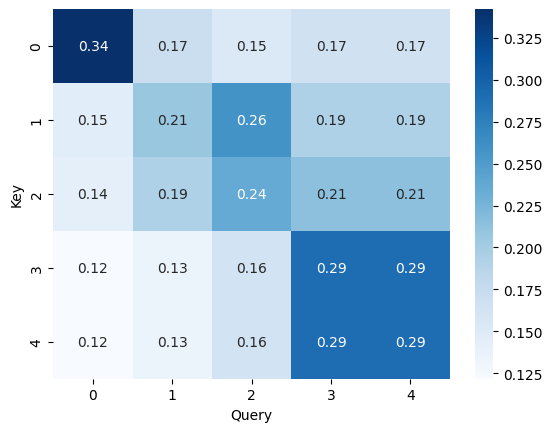

array([[0.3422436 , 0.17211176, 0.15283185, 0.1664064 , 0.1664064 ],
       [0.14650576, 0.20735797, 0.258056  , 0.1940401 , 0.1940401 ],
       [0.14264579, 0.19365641, 0.2356148 , 0.21404146, 0.21404146],
       [0.12169097, 0.13461132, 0.1634371 , 0.2901303 , 0.2901303 ],
       [0.12169097, 0.13461132, 0.1634371 , 0.2901303 , 0.2901303 ]],
      dtype=float32)

In [ ]:
# 실제 단어로 시뮬레이션
vocab = {'<PAD>':0,'<UNK>':1,'영화':2,'재밌다':3,'별로':4,'최고':5}
embedding_layer = nn.Embedding(len(vocab), embed_dim).to(device)
# 영화 재미있다 최고
sample_tokens = torch.LongTensor([[vocab['영화'] # 패딩 추가
                                  ,vocab['재밌다'],vocab['최고'],0,0 ]]).to(device)
print(sample_tokens.shape)
sample_embed = embedding_layer(sample_tokens)
print(sample_embed.shape)
# self attention 적용
out, attn_weight = model(sample_embed)
print(f'샘플 출력 shpae : {out.shape}')
print(f'어텐션 가중치 shape : {attn_weight.shape}')

# 첫번째해드 가중치 시각화 (쿼리와 키들의 어텐션 값)
import seaborn as sns
attn_weights = attn_weight[0,0].detach().cpu().numpy()
sns.heatmap(attn_weights, annot=True, cmap='Blues')
plt.xlabel('Query')
plt.ylabel('Key')
plt.show()
attn_weights  # 가로방향은 key(참조)  세로는 query(질문)
# 영화입장에서는 재밌다   재밌다입장에서는 영화를 제일 많이 봄
# 어텐션이 많이 분산되어 있다.
#  각 행이 query 에 대한 key의 어텐션 가중치

In [ ]:
attn_weights.sum(axis=1)

array([1., 1., 1., 1., 1.], dtype=float32)

Pretraining
```
MLM : Masked Laguage Nodel
  영화가 [mask] 재밌다
  특징 : 양방향 문맥,문장 전체를 보고 단어간 관계 학습
  용도 : 문맥이해가중요한 작업(감성분석, 질의응답)
  빈칸채우기로 문장의 전체 맥락을 이해
CLM : Casual Laguage Nodel
  이전단어들만 보고 다음단어를 예측: 영화가 매우-> 재밌다
  특징:단방향 문맥이해, 텍스트생성에 최적화
  용도 : 텍스트생성(챗봇,스토리생성)
  다음문장 예측하기
BERT vs GPT 학습방식
  BERT 방식 : MLM + NSP(Next Sequence Prediction) 문장의 일부를 마스크한다음 두 문장의 연결 여부 판단
  Transformer Encoder만사용 양방향 문맥학습
  용도 : 텍스트 분류, 질의응답,개체명 인식
  문장을 깊이 분석
GPT(Generative Pre-Trained Transfomer)
  CML : 이전단어로 다음 단어 예측
  Transformer Decoder만사용 , 단방향 학습
  텍스트생성, 대화, 스토리 작성
  창의적인 이야기를 이어간다
BERT는 문맥이해도 GPT 유연한 생성    
```

In [ ]:
import torch
from transformers import BertTokenizer, BertForMaskedLM, GPT2Tokenizer, GPT2LMHeadModel
import pandas as pd
import numpy as np

In [ ]:
# 한글 Bert 와 한글 gpt-2 모델 및 토크나이져
bert_tokenizer = BertTokenizer.from_pretrained('klue/bert-base')
bert_model = BertForMaskedLM.from_pretrained('klue/bert-base')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
bert_model.to(device)
gpt_model.to(device)
# 샘플문장
sample_text = '영화가 매우 재미있다'
masked_text = '영화가 [MASK] 재미있다'
from typing import List, Dict
def predict_bert_maksed(text:str, top_k:int = 5) :
  inputs = bert_tokenizer(text, return_tensors='pt',padding=True
                          , truncation=True).to(device)

  mask_idx = torch.where(inputs['input_ids'] == bert_tokenizer.mask_token_id)[1].item()
  bert_model.eval()
  with torch.no_grad():
    outputs = bert_model(**inputs)
    logits = outputs.logits[0,mask_idx]
    probs = torch.softmax(logits,dim=-1)
    top_probs,top_ids =  torch.topk(probs,k=top_k)
  result = []
  for prob, idx in zip(top_probs, top_ids):
    token = bert_tokenizer.decode([idx.item()])
    result.append({'token':token,'prob':prob.item()})
  return result

bert_result = predict_bert_maksed(masked_text)
print(bert_result)

Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.


[{'token': '너무', 'prob': 0.5043820738792419}, {'token': '참', 'prob': 0.10569418221712112}, {'token': '진짜', 'prob': 0.0575430765748024}, {'token': '정말', 'prob': 0.03511859476566315}, {'token': '더', 'prob': 0.035070035606622696}]


In [ ]:
# 한글 gpt
from transformers import PreTrainedTokenizerFast
gpt_tokenizer = PreTrainedTokenizerFast.from_pretrained("skt/kogpt2-base-v2",
            bos_token='</s>', eos_token='</s>', unk_token='<unk>',
            pad_token='<pad>', mask_token='<mask>')
gpt_model = GPT2LMHeadModel.from_pretrained('skt/kogpt2-base-v2')
def predict_gpt_next(text:str, top_k:int=5):
  inputs = gpt_tokenizer(text,return_tensors='pt', padding=True, truncation=True).to(device)
  input_ids = inputs['input_ids']
  gpt_model.eval()
  with torch.no_grad():
    outputs = gpt_model(**inputs)
    logits =  outputs.logits[0,-1]
    probs = torch.softmax(logits,dim=-1)
    top_probs, top_ids = torch.topk(probs,k=top_k)
  results = []
  for prob, idx in zip(top_probs,top_ids):
    token = gpt_tokenizer.decode([idx.item()])
    results.append({'token':token,'prob':prob.item()})
  return results
gpt_result = predict_gpt_next(sample_text)
print(gpt_result)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


[{'token': '면서', 'prob': 0.21409927308559418}, {'token': '라는', 'prob': 0.09803730994462967}, {'token': '!\n', 'prob': 0.06238093972206116}, {'token': '', 'prob': 0.05613355711102486}, {'token': '라고', 'prob': 0.052700772881507874}]


In [ ]:
sample_text = '이 영화는 정말 재미있고 친구나 가족과 함께 '
masked_text = '이 영화는 [MASK] 재미있고 친구나 가족과 함께 보시는것을 추천합니다.'
print(predict_bert_maksed(masked_text))
print(predict_gpt_next(sample_text))

[{'token': '정말', 'prob': 0.3646480143070221}, {'token': '매우', 'prob': 0.13457666337490082}, {'token': '너무', 'prob': 0.12855878472328186}, {'token': '아주', 'prob': 0.08438378572463989}, {'token': '굉장히', 'prob': 0.050859831273555756}]
[{'token': '봤', 'prob': 0.44383004307746887}, {'token': '#', 'prob': 0.07271353155374527}, {'token': '<unk>', 'prob': 0.04385720193386078}, {'token': '뭔', 'prob': 0.04302525520324707}, {'token': '괜', 'prob': 0.03127119690179825}]


GPT-2, GPT-3
```
  구조 : Transfromer의 Deocoder만 사용 Masked Self-Attention 이전 단어만 참고 CLM
GPT-2
  레이어 수 12~48개
  파라메터 : 1.5G
  다양한 텍스트 생성기능, 한국어 지원 모델 skt/kogpt2-base-v2
GPT-3
  레이어 수 96개
  파라메터:175G
  대규모데이터로 학습, zero-shot, few-shot성능이 뛰어남
LayerNorm
  각 레이어의 출력을 정규화
Residual
  잔차의 합...
  입력을 이후 출력에 더함(정보손실방지)  
Attention Head      
  단어간 병렬계산(gpt2 12, gpt3 96)
```

In [ ]:
from transformers import PreTrainedTokenizerFast
tokenizer = PreTrainedTokenizerFast.from_pretrained("skt/kogpt2-base-v2",
  bos_token='</s>', eos_token='</s>', unk_token='<unk>',
  pad_token='<pad>', mask_token='<mask>')
model = GPT2LMHeadModel.from_pretrained('skt/kogpt2-base-v2')

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.


In [ ]:
def generate_text(prompt:str, max_length:int=50,temperature:float=1.0,
                  top_k:int=0, top_p:float=1.0,label=None):
  inputs = tokenizer(prompt, return_tensors='pt',padding=True
                     , truncation=True).to(device)
  input_ids = inputs['input_ids']
  outputs = model.generate(
    input_ids,
    max_length = max_length,
    temperature = temperature,  # 생성의 다양성(낮을수록 보수적)
    top_k = top_k if top_k > 0 else None, #상위 k개의 토큰
    top_p = top_p if top_p < 1.0 else None, # 누적 확률 p까지 고려
    do_sample = True,
    num_return_sequences = 1,
    pad_token_id = tokenizer.pad_token_id,
  )
  generated_token= tokenizer.decode(outputs[0],skip_special_tokens=True)
  with torch.no_grad():
    logits = model(input_ids).logits[0,-1] # 마지막 토큰의 로짓
    probs = torch.softmax(logits, dim=-1)
    top_probs, top_idx = torch.topk(probs,5)
    top_tokens = [tokenizer.decode([idx.item()]) for idx in top_idx]
  return{
      "text" : generated_token,
      "logits" : logits[:5].cpu().numpy(),
      "probs" : top_probs.cpu().numpy(),
      "top_tokens" : top_tokens,
      'label' : label
  }

In [ ]:
prompt = "영화 리뷰: 이 영화는"
options = [
 {'prompt':prompt,'temperature':0.7,"top_k":0, "top_p":1.0,'max_length':50,"label":"t:0.7"},
 {'prompt':prompt,'temperature':1.2,"top_k":0, "top_p":1.0,'max_length':50,"label":"t:1.2"},
 {'prompt':prompt,'temperature':0.7,"top_k":50, "top_p":1.0,'max_length':50,"label":"top_k: 50"},
 {'prompt':prompt,'temperature':0.7,"top_k":0, "top_p":0.9,'max_length':50,"label":"top_k: 0.9"},
 {'prompt':prompt,'temperature':0.5,"top_k":0, "top_p":1.0,'max_length':50,"label":"t:0.5"},
]
results = [ generate_text(**op) for op in options]

In [ ]:
for result in results:
  print(result['label'])
  print('생성 문장:',result['text'])
  print(f'마지막 토큰의 상위 5개')
  for token, prob in zip(result['top_tokens'],result['probs']):
    print(f'토큰:{token}, 확률:{prob}')
  print(f'로짓(상위 5개) : {result["logits"]}')

t:0.7
생성 문장: 영화 리뷰: 이 영화는 2003년 12월 13일 개봉한 장편 애니메이션 영화다.
'지킬 앤 하이드'가 처음 개봉한 영화다.
이 영화는 전 세계적으로 1천만 부 이상의 판매고를 올렸다.
이 영화는 악덕 기업들을 상대로 한 범죄가 거의 근절
마지막 토큰의 상위 5개
토큰:,, 확률:0.014031452126801014
토큰:201, 확률:0.009948944672942162
토큰:', 확률:0.008132383227348328
토큰:영화, 확률:0.007377454079687595
토큰:한국, 확률:0.006975746247917414
로짓(상위 5개) : [-4.7485695 -4.66481   -4.9093947 -6.1892166 -5.1998878]
t:1.2
생성 문장: 영화 리뷰: 이 영화는 “진정한 페이퍼는 What, Spad Sch 임명되었으며, 생애에 Eidshirts, pator- five, 다음의,”에 길이 수집한 리뷰 및 기록 기간은 33억 달러이다.
중을 제외한 나머지
마지막 토큰의 상위 5개
토큰:,, 확률:0.014031452126801014
토큰:201, 확률:0.009948944672942162
토큰:', 확률:0.008132383227348328
토큰:영화, 확률:0.007377454079687595
토큰:한국, 확률:0.006975746247917414
로짓(상위 5개) : [-4.7485695 -4.66481   -4.9093947 -6.1892166 -5.1998878]
top_k: 50
생성 문장: 영화 리뷰: 이 영화는 내년에 개봉한다.
<그것이 알고 싶다
>는 영화 <그것이 알고 싶다
>의 후속편이다.
제작진은 내년에 개봉할 <그것이 알고 싶다
>를 만들 계획이다.
영화는 내년 봄에 개봉
마지막 토큰의 상위 5개
토큰:,, 확률:0.014031452126801014
토큰:201, 확률:0.009948944672942162
토큰:', 확률:0.008132383227348328
토큰:영화, 확률:0.0

미니 GPT (Fine-tuning)
```
파인튜닝: 사전학습된모델을 특정 작업에 맞게 추가 학습
목표 : 모델이 도메인별(한국어 영화리뷰) 데이터에 적응해 더 적합 출력 생성
방법:
  full fine-tuning : 모든 파라메터를 업데이트,성능좋음
  parameter-Efficient Fine-tuning : 일부 파라메터만 수정(LoRA)
전략
  작은학습률: 사전 학습된 지식 보전
  적절한 데이터셋 : 적으면 과적합, 많으면 비용상승
  정규화:(Dropout, Weight Decay) 과적합방지 및 원할한 학습
Dataset
  전처리:토큰화,패딩,특수토큰 추가    
직접학습루프 작성
  데이터로드
  옵티마이져
  손실함수
  학습루프
  등등..  
```

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from transformers import PreTrainedTokenizerFast
from transformers import GPT2LMHeadModel
from torch.utils.data import Dataset, DataLoader

In [ ]:
!wget http://skt-lsl-nlp-model.s3.amazonaws.com/KoBERT/datasets/nsmc/ratings_train.txt

--2025-04-28 05:10:59--  http://skt-lsl-nlp-model.s3.amazonaws.com/KoBERT/datasets/nsmc/ratings_train.txt
Resolving skt-lsl-nlp-model.s3.amazonaws.com (skt-lsl-nlp-model.s3.amazonaws.com)... 52.219.146.91, 3.5.188.18, 52.219.206.71, ...
Connecting to skt-lsl-nlp-model.s3.amazonaws.com (skt-lsl-nlp-model.s3.amazonaws.com)|52.219.146.91|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14628807 (14M) [text/plain]
Saving to: ‘ratings_train.txt’

ratings_train.txt   100%[===================>]  13.95M  9.42MB/s    in 1.5s    

2025-04-28 05:11:00 (9.42 MB/s) - ‘ratings_train.txt’ saved [14628807/14628807]



In [ ]:
nsmc_df = pd.read_csv('ratings_train.txt',sep='\t')[:5000]
nsmc_df.dropna(inplace=True)
nsmc_df.drop_duplicates(inplace=True)
texts = nsmc_df['document'].tolist()

In [ ]:
# 데이터 셋
class NSMCDataSet(Dataset):
  def __init__(self,texts: list, tokenizer,max_length:int = 128) -> None:
    self.tokenizer = tokenizer
    self.max_len = max_length
    self.inputs = []
    for text in texts:
      input_ids = tokenizer(
          text,
          max_length = max_length,
          padding = 'max_length',
          truncation = True,
          return_tensors = 'pt'
      )
      self.inputs.append(input_ids)

  def __len__(self):
    return len(self.inputs)
  def __getitem__(self, index):
    input_ids = self.inputs[index]['input_ids'].squeeze()
    attention_mask = self.inputs[index]['attention_mask'].squeeze()
    return input_ids,attention_mask

In [ ]:
# 모델 , 토크나이저 로드
tokenizer = PreTrainedTokenizerFast.from_pretrained("skt/kogpt2-base-v2",
  bos_token='</s>', eos_token='</s>', unk_token='<unk>',
  pad_token='<pad>', mask_token='<mask>')

model = GPT2LMHeadModel.from_pretrained('skt/kogpt2-base-v2')
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# 데이터셋 및 데이터 로더 준비
dataset = NSMCDataSet(texts, tokenizer)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.


In [ ]:
batch,attention_mask = next(iter(dataloader))

In [ ]:
# 학습설정
optimizer = torch.optim.AdamW(model.parameters(), lr= 2e-5)
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
#  학습루프
num_epochs = 5
for epoch in range(num_epochs):
  epoch_loss = 0.0
  for batch,attention_mask in dataloader:
    batch = batch.to(device)
    attention_mask = attention_mask.to(device)
    # 순전파(예측)
    outputs = model(input_ids=batch,labels=batch,attention_mask=attention_mask)
    loss = outputs.loss
    # 역전파
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    epoch_loss += loss.item()
  print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(dataloader)}")


Epoch 1/5, Loss: 0.853109169406251
Epoch 2/5, Loss: 0.6205552824960349
Epoch 3/5, Loss: 0.5407294276804208
Epoch 4/5, Loss: 0.4467774357277745
Epoch 5/5, Loss: 0.3407143908091627


In [ ]:
# 모델 저장
model.save_pretrained('nsmc_gpt2_5000')
tokenizer.save_pretrained('nsmc_gpt2_5000')

('nsmc_gpt2_5000/tokenizer_config.json',
 'nsmc_gpt2_5000/special_tokens_map.json',
 'nsmc_gpt2_5000/tokenizer.json')

In [ ]:
# 모델 불러오기 및 생성 테스트
finetuned_model = GPT2LMHeadModel.from_pretrained('nsmc_gpt2_5000')
finetuned_tokenizer = PreTrainedTokenizerFast.from_pretrained('nsmc_gpt2_5000')

In [ ]:
# 생성 테스트
def generated_text(model, tokenizer,prompt:str
                   , max_length:int=128,temperature:float = 0.7)->str:
  model.eval()
  input_ids = tokenizer(prompt, return_tensors='pt',padding=True
                     , truncation=True).to(device)

  outputs = model.generate(
      input_ids['input_ids'],
      max_length = max_length,
      temperature = temperature,  # 생성의 다양성(낮을수록 보수적)
      do_sample=True,
      num_return_sequences = 1,
      pad_token_id = tokenizer.pad_token_id,
  )
  return tokenizer.decode(outputs[0],skip_special_tokens=True)

In [ ]:
finetuned_model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(51200, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=51200, bias=False)
)

In [ ]:
prompt = '순이와 함께 보는 영화는'
output_text = generated_text(finetuned_model,finetuned_tokenizer,prompt)
print(output_text)

순이와 함께 보는 영화는 이렇게 별1개도 아까운 드라마짜짜반쪽인 사람들의 얘기를 들춰낸 영화


In [ ]:
prompt = '이 영화의 최대 포인트는'
output_text = generated_text(finetuned_model,finetuned_tokenizer,prompt)
print(output_text)

# 생성될 단어의 확률
inputs = tokenizer(prompt, return_tensors='pt',padding=True,truncation=True).to(device)
with torch.no_grad():
   outputs = finetuned_model(**inputs)
   logits = outputs.logits[0,-1]
   probs = torch.softmax(logits, dim=-1)
   top_probs, top_ids = torch.topk(probs, 5)
   top_tokens = [  finetuned_tokenizer.decode([idx.item()]) for idx in top_ids]
print(f'마지막 토큰 로짓(상위 5개):{logits[:5].cpu().numpy()}')
for token, prob in zip(top_tokens, top_probs):
  print(f'토큰:{token}, 확률:{prob:.4f}')

이 영화의 최대 포인트는 바로 주인공들의 연기력이다. 이 영화의 백미는 바로 이 여자다.athall로 가는 내내 실컷 웃고 싶었던 영화
마지막 토큰 로짓(상위 5개):[-3.2963753 -5.359368  -6.45333    2.3962643 -6.5279503]
토큰:역시, 확률:0.0669
토큰:이영, 확률:0.0489
토큰:이, 확률:0.0305
토큰:왜, 확률:0.0250
토큰:단연, 확률:0.0232


텍스트 생성 모델 심화
```
Sampling 전략
  텍스트생성 핵심: 각 단계에서 다음 토큰을 예측
  Greedy Search:
    매번 가장 높은 확률의 토큰 선택
    빠르고 간단
    단점 : 창의성이 부족 ,결과가 단조롭다
  Beam Searh:
    상위 k개 시퀀스를 병렬로 추적, 최종적으로 최고 점수 스퀀스선택
    더 논리적이고 일관됨 문장
  Top-k-Sampling:
    상위 k개토큰중에 무작위
    창의성과 품질이 균형
  Temperature:
    로짓을 조정해서 확률분포변경
      낮은값 : 0.7 확률분포가 뽀족, 보수적
      높은값 : 1.2 확률분포 평평, 창의적/래덤 선택   
응용.스토리생성,스타일 변화
  스토리생성
    프롬프트(시작문장) 제공->모델이 이어서 이야기 생성
  스타일 변화
    모델이 특정 스타일(공식적, 캐주얼, 문학적)로 텍스트를 생성

```

In [ ]:
# 한글 gpt2 모델 과 토크나이져 로드
tokenizer = PreTrainedTokenizerFast.from_pretrained("skt/kogpt2-base-v2",
                  bos_token='</s>', eos_token='</s>', unk_token='<unk>',
                  pad_token='<pad>', mask_token='<mask>')
model = GPT2LMHeadModel.from_pretrained('skt/kogpt2-base-v2').to(device)
# 문장 생성 함수
def generated_text(
    prompt:str,   # 입력 프롬프트
    max_length:int = 100,  # 최대 생성길이
    temperature: float=1.0,  # 생성 다양성(낮을수록 보수적)
    top_k:int=0,  # 상위 k개의 토큰만 고려
    top_p:float=1.0, # 누적확률 p까지 토큰 고려
    num_beams:int = 1, # Beam Searh의 빔수
    do_sample:bool=True # 샘플링 여부
    )->dict:  # 생성 텍스트와 마지막 토큰의 로짓/확률
  model.eval()
  input_ids = tokenizer(prompt, return_tensors='pt',padding=True
                     , truncation=True).to(device)
  # Greedy Searh인경우 do_sample=False, num_beams=1
  if num_beams == 1 and top_k ==0 and top_p == 1.0 and temperature == 1.0:
    do_sample = False
  input_ids = input_ids['input_ids']
  outputs = model.generate(
      input_ids,
      max_length = max_length,
      temperature = temperature,  # 생성의 다양성(낮을수록 보수적)
      top_k = top_k if top_k >0 else None,
      top_p = top_p if top_p < 1.0 else None,
      num_beams = num_beams,
      do_sample=do_sample,
      num_return_sequences = 1,
      pad_token_id = tokenizer.pad_token_id,
      no_repeat_ngram_size=2  # 반복방지
  )
  output_text = tokenizer.decode(outputs[0],skip_special_tokens=True)
  # 마지막 토큰의 로짓과 확률
  with torch.no_grad():
    logits = model(input_ids).logits[0,-1]  # 프롬프트의 마지막 토큰의 로짓
    probs = torch.softmax(logits / temperature, dim=-1)
    top_probs, top_ids =  torch.topk(probs, 5)
    top_tokens = [  tokenizer.decode([idx.item()])  for idx in top_ids ]
  return{
      'text': output_text
      ,'logits': logits[:5].cpu().numpy()
      ,'probs': top_probs.cpu().numpy()
      ,'top_tokens': top_tokens
  }

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.


In [ ]:
prompt = '옛날의 한 마을에'
generated_text(prompt,temperature=0.9,top_k = 50)

{'text': '옛날의 한 마을에 서 있다. 그들은 아주 좋은 물건을 가지고 있다."\n우리는 모두 입을 모아 이야기한다.\n"이 마을이 정말 좋은 곳입니다."\n그러나 우리는 모두 고개를 갸웃거리고 만다.\n그들 역시 모두 기분 나쁘다고 이야기하기 때문이다.\n우리는 우리가 알고 있는 것과 같은 이야기를 한다.\n그 이유는 우리와 똑같은 이야기의 내용이 반복되었을 때, 우리가 알지 못하는 것이 더 많은 이야기에 나오는 것이 아닐까?\n우리는 우리와는 다른 이야기를 하지 않기 때문이다.\n그러나 이 이야기의 첫머리는 우리가 모르는 것이 있다는 것을 알고 있을 뿐이라는 것이다.\n우리는 마치',
 'logits': array([-4.7084203, -5.9164786, -5.5396094, -5.503705 , -4.4116774],
       dtype=float32),
 'probs': array([0.0764983 , 0.0759229 , 0.04554147, 0.02945458, 0.01672325],
       dtype=float32),
 'top_tokens': ['사는', '살고', '있는', '살던', '도착']}

텍스트 요약
```
Extractive Summarization
  원문에서 중요한 문장/구절을 그대로 추출해 요약생성(뉴스기사에서 핵심문장 3개 선택)
  장점 : 구조간단
  단점 : 자연스럽지 않음

Abstractive Summarization
  원문의 의미를 이해하고 새로운 문장으로 재구성(뉴스기사를 한 문장으로 요약)
  장점 : 인간처럼 자연스러운 요약
  단점 : 의미 왜곡

GPT
  GPT계열은 CLM 기반, 텍스트 생성에 강함
  한계 : Decoder-only 모델, 요약처럼 입력 문맥을 깊이 이해하는데 약함
  비유 : gpt 이야기를 이어나가는 소설가, 요약은 전체를 분석하는 편집자역활
BERT
  encoder-decoder 문맥을 이해하는 최적화
평가방법
  ROUGE(Recall-Oriented Understudy for Gistion Evaluation)
    생성요약과 참조요약(정답) 간 단어/구문 중복 측정  
    종류
      ROUGE-N : N-gram 중복(1그램은 단어, 2그램은 단어쌍)
      ROUGE-L : 최장 공통부분열(LCS)기반, 문장구조 반영
      점수 : 0~1 높을수록 유사
      예측한 요약과 정답의 요약의 단어가 얼마나 일치하는지
      BLUE(Billingual Evaluation Understudy):
        생성과 참조간의 n-gram 정밀도
        기계번역에 주로 사용
        번역문과 원문의 단어 일치도 체크
```

In [ ]:
from transformers import PreTrainedTokenizerFast, BartForConditionalGeneration
tokenizer =  PreTrainedTokenizerFast.from_pretrained("gogamza/kobart-summarization")
model = BartForConditionalGeneration.from_pretrained("gogamza/kobart-summarization")

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels will be overwritten to 2.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BartTokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.
You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels will be overwritten to 2.


model.safetensors:   0%|          | 0.00/496M [00:00<?, ?B/s]

In [ ]:
import torch
import torch.nn as nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

BartForConditionalGeneration(
  (model): BartModel(
    (shared): BartScaledWordEmbedding(30000, 768, padding_idx=3)
    (encoder): BartEncoder(
      (embed_tokens): BartScaledWordEmbedding(30000, 768, padding_idx=3)
      (embed_positions): BartLearnedPositionalEmbedding(1028, 768)
      (layers): ModuleList(
        (0-5): 6 x BartEncoderLayer(
          (self_attn): BartSdpaAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (final_lay

In [ ]:
# 샘플 뉴스 기사 및 참조 요약
nws_articles = [
    'text': '''
      28일 오후 2시 1분께 대구 북구 노곡동 함지산에서 난 불이 바람을 타고 계속해서 확산하고 있다.
      산림 당국은 오후 3시 50분 현재 산불 대응 2단계를 발령하고 헬기 19대와 장비 38대, 인력 165명을 투입해 진화 작업을 벌이고 있다.
      산불 2단계는 예상 피해 면적이 50∼100㏊, 평균 풍속 7∼11m/s, 예상 진화 10∼48시간 미만일 때 발령된다.
        '''
    ,'reference_summary' :
]